In [1]:
import cv2
import  numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Flatten,BatchNormalization,Activation
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras import optimizers
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

broken='Broken_grain/broken_grain_3.jpg'
full='Full_grain/full_grain_3.jpg'
def crop_resize_img(img):
    ht,wd=img.shape
    ww=300
    hh=300
    color=0
    result = np.full((hh,ww), color, dtype=np.uint8)
    xx=(ww - wd)//2
    yy=(hh - ht)//2
    result[yy:yy+ht,xx:xx+wd]=img

    final =cv2.resize(result,(50,50))
    
    return final

In [2]:
def pre_process_And_Count(image_path, output_path):

    input_rice = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    output_adapthresh = cv2.adaptiveThreshold (input_rice, 255.0, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, -20.0)

    cv2.imwrite('rice_adapthresh.png', output_adapthresh)
    
    kernel = np.ones((5,5),np.uint8)
    output_erosion = cv2.erode(output_adapthresh, kernel)

    cv2.imwrite('rice_erosion.png', output_erosion)
    
    contours, hierarchy = cv2.findContours(output_erosion, cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_SIMPLE)
    output_contour = cv2.cvtColor(input_rice, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(output_contour, contours, -1, (0, 0, 255), 2)
    print("Number of detected contours", len(contours))
    
    cv2.imwrite('rice_contours.png', output_contour)
    
    k=1
    temp = 0.70 * len(contours)
    for i in contours:
        x, y, width, height = cv2.boundingRect(i)
        roi = output_erosion[y:y+height, x:x+width]
        roi=crop_resize_img(roi)
        path  = ''
        if output_path !='mixed/mixed_':
            if k<temp:
                path = 'dataset/train/'+output_path

            else:
                path = 'dataset/test/'+output_path
        else:
            path = output_path
        cv2.imwrite(path+str(k)+".png", roi)
        k+=1

In [3]:
import os
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
create_directory('dataset')
create_directory('dataset/train')
create_directory('dataset/test')
create_directory('dataset/train/full_rice')
create_directory('dataset/test/full_rice')
create_directory('dataset/train/broken_rice')
create_directory('dataset/test/broken_rice')
pre_process_And_Count(full, 'full_rice/full_')

Number of detected contours 680


In [4]:
pre_process_And_Count(broken, 'broken_rice/broken_')

Number of detected contours 937


In [5]:
image_size = (50,50)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(50,50),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)


validation_generator = test_datagen.flow_from_directory(
    "dataset/test",
    target_size=(50, 50),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

Found 1130 images belonging to 2 classes.
Found 487 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'broken_rice': 0, 'full_rice': 1}

In [7]:
a, b = next(train_generator)
a.shape

(32, 50, 50, 1)

In [8]:
img_width = 50
img_height = 50

# Check for TensorFlow or Thieno
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
input_shape

(50, 50, 1)

In [9]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.Adam(lr=.0001),
              metrics=['accuracy'])

hist = model.fit_generator(train_generator,steps_per_epoch=10,epochs=200,validation_data=validation_generator,validation_steps=2)

C:\Users\LAZ\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\LAZ\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
10/10 [==============================] - 2s 139ms/step - loss: 0.6926 - accuracy: 0.5168 - val_loss: 0.6939 - val_accuracy: 0.5469
Epoch 2/200
10/10 [==============================] - 1s 127ms/step - loss: 0.6837 - accuracy: 0.5813 - val_loss: 0.6807 - val_accuracy: 0.5625
Epoch 3/200
10/10 [==============================] - 1s 124ms/step - loss: 0.6751 - accuracy: 0.6031 - val_loss: 0.6445 - val_accuracy: 0.6875
Epoch 4/200
10/10 [==============================] - 1s 123ms/step - loss: 0.6655 - accuracy: 0.6094 - val_loss: 0.7159 - val_accuracy: 0.5156
Epoch 5/200
10/10 [==============================] - 1s 126ms/step - loss: 0.6867 - accuracy: 0.5500 - val_loss: 0.6678 - val_accuracy: 0.6250
Epoch 6/200
10/10 [==============================] - 1s 124ms/step - loss: 0.6888 - accuracy: 0.5156 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 7/200
10/10 [==============================] - 1s 123ms/step - loss: 0.6755 - accuracy: 0.6000 - val_loss: 0.6724 - val_accuracy: 0.5781

Epoch 58/200
10/10 [==============================] - 1s 121ms/step - loss: 0.4396 - accuracy: 0.7750 - val_loss: 0.4552 - val_accuracy: 0.7969
Epoch 59/200
10/10 [==============================] - 1s 122ms/step - loss: 0.4734 - accuracy: 0.7656 - val_loss: 0.5212 - val_accuracy: 0.7344
Epoch 60/200
10/10 [==============================] - 1s 122ms/step - loss: 0.4563 - accuracy: 0.7812 - val_loss: 0.6720 - val_accuracy: 0.6094
Epoch 61/200
10/10 [==============================] - 1s 122ms/step - loss: 0.4537 - accuracy: 0.7875 - val_loss: 0.6895 - val_accuracy: 0.6562
Epoch 62/200
10/10 [==============================] - 1s 121ms/step - loss: 0.3932 - accuracy: 0.8281 - val_loss: 0.5334 - val_accuracy: 0.7188
Epoch 63/200
10/10 [==============================] - 1s 119ms/step - loss: 0.4154 - accuracy: 0.7688 - val_loss: 0.5829 - val_accuracy: 0.6719
Epoch 64/200
10/10 [==============================] - 1s 121ms/step - loss: 0.4135 - accuracy: 0.8125 - val_loss: 0.4654 - val_accuracy:

Epoch 115/200
10/10 [==============================] - 1s 122ms/step - loss: 0.4034 - accuracy: 0.7844 - val_loss: 0.4300 - val_accuracy: 0.7812
Epoch 116/200
10/10 [==============================] - 1s 124ms/step - loss: 0.4272 - accuracy: 0.8094 - val_loss: 0.4873 - val_accuracy: 0.7812
Epoch 117/200
10/10 [==============================] - 1s 122ms/step - loss: 0.3988 - accuracy: 0.8219 - val_loss: 0.4444 - val_accuracy: 0.7969
Epoch 118/200
10/10 [==============================] - 1s 123ms/step - loss: 0.4119 - accuracy: 0.8219 - val_loss: 0.5820 - val_accuracy: 0.7500
Epoch 119/200
10/10 [==============================] - 1s 123ms/step - loss: 0.3725 - accuracy: 0.8375 - val_loss: 0.4537 - val_accuracy: 0.8594
Epoch 120/200
10/10 [==============================] - 1s 123ms/step - loss: 0.3759 - accuracy: 0.8154 - val_loss: 0.3854 - val_accuracy: 0.7500
Epoch 121/200
10/10 [==============================] - 1s 123ms/step - loss: 0.3703 - accuracy: 0.8469 - val_loss: 0.5139 - val_ac

10/10 [==============================] - 1s 127ms/step - loss: 0.3753 - accuracy: 0.8289 - val_loss: 0.3787 - val_accuracy: 0.8281
Epoch 172/200
10/10 [==============================] - 1s 116ms/step - loss: 0.3982 - accuracy: 0.8054 - val_loss: 0.3642 - val_accuracy: 0.8594
Epoch 173/200
10/10 [==============================] - 1s 135ms/step - loss: 0.3342 - accuracy: 0.8500 - val_loss: 0.3961 - val_accuracy: 0.7812
Epoch 174/200
10/10 [==============================] - 1s 126ms/step - loss: 0.3921 - accuracy: 0.8188 - val_loss: 0.4587 - val_accuracy: 0.7969
Epoch 175/200
10/10 [==============================] - 1s 139ms/step - loss: 0.3522 - accuracy: 0.8531 - val_loss: 0.6319 - val_accuracy: 0.7344
Epoch 176/200
10/10 [==============================] - 1s 145ms/step - loss: 0.3437 - accuracy: 0.8438 - val_loss: 0.5086 - val_accuracy: 0.7188
Epoch 177/200
10/10 [==============================] - 2s 150ms/step - loss: 0.3283 - accuracy: 0.8656 - val_loss: 0.4827 - val_accuracy: 0.7344

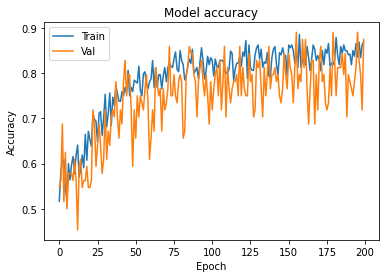

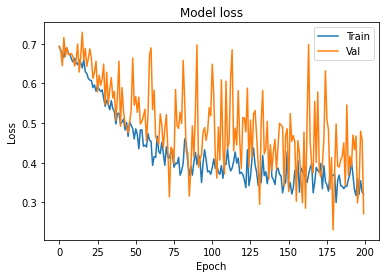

In [10]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [11]:
create_directory('mixed')

In [12]:
mixed = input()

Mixed_grain/image_2.jpg


In [13]:
pre_process_And_Count(mixed, 'mixed/mixed_')

Number of detected contours 595


In [14]:
import os
from os import listdir
from os.path import isfile, join

In [15]:
import os
from os import listdir
from os.path import isfile, join

predict_dir_path='mixed/'
onlyfiles = [f for f in listdir(predict_dir_path) if isfile(join(predict_dir_path, f))]

from keras.preprocessing import image
full = 0 
broken  = 0
for file in onlyfiles:
    img = image.load_img(predict_dir_path+'/'+file, target_size=(img_width, img_height), grayscale=True)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = model.predict(images, batch_size=32)
    classes = classes[0][0]
    if classes == 0:
        broken += 1
    else:
        full += 1
    
print("Total full :",full)
print("Total broken :",broken)

C:\Users\LAZ\AppData\Roaming\Python\Python39\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Total full : 380
Total broken : 215


In [16]:
print("Total rice grains-", (broken+full))

Total rice grains- 595
